In [17]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
from Data_Augmentation.vpower_src.utils.auxiliary_functions import *
import matplotlib.pyplot as plt

In [18]:
#!pip install deep_tabular_augmentation
!pip install sdv==1.3.0

Defaulting to user installation because normal site-packages is not writeable


In [19]:
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.lite import SingleTablePreset
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import CopulaGANSynthesizer

In [20]:
torch.cuda.is_available()

True

In [21]:
data_dir_s =  "../../Data/synthetic_data"
data_dir_r =  "../../Data/split_quad"
data_dir_da = "../../Data/augmented_data"
data_tag="RD"


In [22]:
# Load data partitions and assign them to dictionary data_all
data_all = {}
#for partition in ["train", "dev_in", "dev_out"]:
#    df = load_data_and_set_index(filepath=os.path.join(data_dir_s, f"{partition}.csv"), index_column_name="index")
#    data_all[partition+"_s"] = df
for partition in ["train", "test", "val", "lourd"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_r, f"{partition}.csv"), index_column_name="index")
    data_all[partition+"_r"] = df

if data_tag=="RD":
    data_all["train"]=data_all["train_r"]
    data_all["test"]=data_all["test_r"]
else:
    data_all["train"]=   pd.concat([data_all["train_r"], data_all["train_s"]])
    data_all["test"] = pd.concat([data_all["test_r"], data_all["test_s"]])
    

data_flight1 = {}
data_flight1["train"] = data_all["train"].loc[data_all["train"]["flight"] == 1]
data_flight1["test"] = data_all["test"].loc[data_all["test"]["flight"] == 1]
data_flight1["train"]


,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
112,2019-04-07 10:13:00,1,0.00,1.4,37.0,24.178350,0.389637,-79.782396,40.458047,270.407091,...,-0.000479,0.033248,-0.114812,-9.824341,4,0,25,R5,9.420778,9.420778
113,2019-04-07 10:13:00,1,0.21,1.4,36.0,23.517269,6.154673,-79.782396,40.458047,270.432353,...,0.011397,0.042173,-0.108319,-9.837841,4,0,25,R5,144.741104,144.741104
114,2019-04-07 10:13:00,1,0.31,1.4,42.0,24.109488,1.025779,-79.782396,40.458047,270.433609,...,0.017794,0.005411,-0.188141,-9.812851,4,0,25,R5,24.731003,24.731003
115,2019-04-07 10:13:00,1,0.50,1.4,42.0,24.189619,0.278312,-79.782396,40.458047,270.459037,...,-0.005043,0.034055,-0.114786,-9.808225,4,0,25,R5,6.732263,6.732263
116,2019-04-07 10:13:00,1,0.61,1.3,41.0,24.192123,0.389637,-79.782396,40.458047,270.460150,...,-0.012929,0.008335,-0.094107,-9.812603,4,0,25,R5,9.426145,9.426145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2019-04-07 10:13:00,1,169.10,1.7,92.0,22.500603,5.033473,-79.782354,40.458037,268.150388,...,0.022862,0.264301,0.581728,-9.760308,4,0,25,R5,113.256177,113.256177
1240,2019-04-07 10:13:00,1,169.20,1.7,90.0,22.493092,5.089135,-79.782354,40.458037,268.170896,...,-0.011390,0.207800,0.540354,-9.742634,4,0,25,R5,114.470383,114.470383
1241,2019-04-07 10:13:00,1,169.30,1.7,92.0,22.498098,5.025521,-79.782354,40.458037,268.153808,...,-0.000938,0.246509,0.592650,-9.784649,4,0,25,R5,113.064672,113.064672


In [23]:
input_features = [
    #time_start,
    "flight",
    "time",
    "wind_speed",
    "wind_angle",
    #battery_voltage,
    #battery_current,
    #position_x,
    #position_y,
    "position_z",
    "orientation_x",
    "orientation_y",
    "orientation_z",
    "orientation_w",
    "velocity_x",
    "velocity_y",
    "velocity_z",
    "angular_x",
    "angular_y",
    "angular_z",
    "linear_acceleration_x",
    "linear_acceleration_y",
    "linear_acceleration_z",
    #speed,
    #payload,
    #altitude,
    #route,
    #power,
    "power_smoothed"
]

In [24]:
data_flight1["train"] = pd.DataFrame(data_flight1["train"][input_features])
data_flight1["test"] = pd.DataFrame(data_flight1["test"][input_features])

In [25]:
real_data=data_all["train"]
len(real_data)

139006

In [26]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)
print('Auto detected data:\n')
metadata

Auto detected data:



{
    "columns": {
        "time_start": {
            "sdtype": "categorical"
        },
        "flight": {
            "sdtype": "numerical"
        },
        "time": {
            "sdtype": "numerical"
        },
        "wind_speed": {
            "sdtype": "numerical"
        },
        "wind_angle": {
            "sdtype": "numerical"
        },
        "battery_voltage": {
            "sdtype": "numerical"
        },
        "battery_current": {
            "sdtype": "numerical"
        },
        "position_x": {
            "sdtype": "numerical"
        },
        "position_y": {
            "sdtype": "numerical"
        },
        "position_z": {
            "sdtype": "numerical"
        },
        "orientation_x": {
            "sdtype": "numerical"
        },
        "orientation_y": {
            "sdtype": "numerical"
        },
        "orientation_z": {
            "sdtype": "numerical"
        },
        "orientation_w": {
            "sdtype": "numerical"
        },
 

In [27]:
# A: GaussianCopulaSynthesizer

# Step 1.A: Create the synthesizer
synthesizer_Gaussian = GaussianCopulaSynthesizer(metadata)

In [28]:
# B: CopulaGANSynthesizer

# Step 1.B: Create the synthesizer
synthesizer_GAN = CopulaGANSynthesizer(metadata)

In [29]:
# Step 2.A: Train the synthesizer
synthesizer_Gaussian.fit(real_data)
synthesizer_Gaussian.save(filepath='my_GaussianCopulaSynthesizer.pkl')

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'time'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'wind_speed'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_voltage'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_current'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'position_y'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/

In [ ]:
# Step 2.B: Train the synthesizer
synthesizer_GAN.fit(real_data)
synthesizer_GAN.save(filepath='my_CopulaGANSynthesizer.pkl')

In [12]:
# Step 3.A: Generate synthetic data
synthetic_data_Gaussian = synthesizer_Gaussian.sample(num_rows=15000)
print(len(synthetic_data_Gaussian))

15000


In [32]:
# Step 3.B: Generate synthetic data
synthetic_data_GAN = synthesizer_GAN.sample(num_rows=15000)
print(len(synthetic_data_GAN))

AttributeError: Error: Sampling terminated. Partial results are stored in a temporary file: .sample.csv.temp. This file will be overridden the next time you sample. Please rename the file if you wish to save these results.
'CopulaGANSynthesizer' object has no attribute '_model'

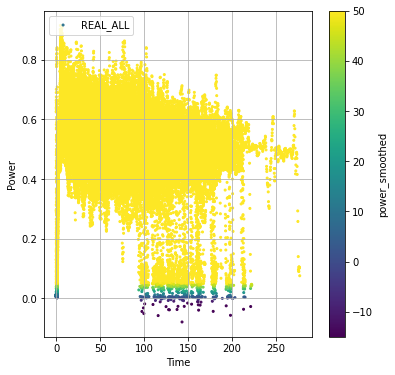

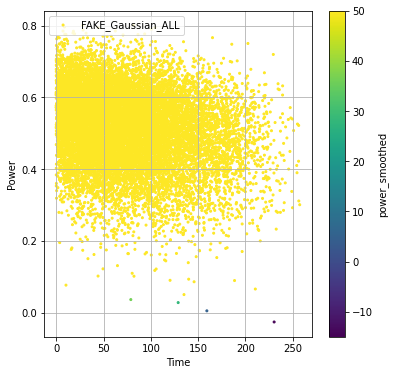

NameError: name 'synthetic_data_GAN' is not defined

<Figure size 432x432 with 0 Axes>

In [13]:
############################################################ Real Data
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(real_data["time"], real_data['power_smoothed'] / 1e3,
            c=real_data[feature_under_study],
            s=4, label="REAL_ALL")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################################ Gaussian
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_Gaussian["time"],synthetic_data_Gaussian['power_smoothed'] / 1e3,
            c=synthetic_data_Gaussian[feature_under_study],
            s=4, label="FAKE_Gaussian_ALL")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################################ GAN
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_GAN["time"],synthetic_data_GAN['power_smoothed'] / 1e3,
            c=synthetic_data_GAN[feature_under_study],
            s=4, label="FAKE_GAN_ALL")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

# Data Augmentation only on 1 flight

In [10]:
real_data_flight1 = data_flight1["train"]
print("Real_Data Length", len(real_data_flight1))

metadata_flight1 = SingleTableMetadata()
metadata_flight1.detect_from_dataframe(data=real_data_flight1)
print("Auto detected data:\n", metadata_flight1)

Real_Data Length 815
Auto detected data:
 {
    "columns": {
        "flight": {
            "sdtype": "numerical"
        },
        "time": {
            "sdtype": "numerical"
        },
        "wind_speed": {
            "sdtype": "numerical"
        },
        "wind_angle": {
            "sdtype": "numerical"
        },
        "position_z": {
            "sdtype": "numerical"
        },
        "orientation_x": {
            "sdtype": "numerical"
        },
        "orientation_y": {
            "sdtype": "numerical"
        },
        "orientation_z": {
            "sdtype": "numerical"
        },
        "orientation_w": {
            "sdtype": "numerical"
        },
        "velocity_x": {
            "sdtype": "numerical"
        },
        "velocity_y": {
            "sdtype": "numerical"
        },
        "velocity_z": {
            "sdtype": "numerical"
        },
        "angular_x": {
            "sdtype": "numerical"
        },
        "angular_y": {
            "sdtyp

In [15]:
# Delete values of Power_Smoothed < 300 (according to the graph obtained with all the data flight values)

real_data_flight1_shorted_train = real_data_flight1[real_data_flight1['power_smoothed'] > 300]

In [64]:
#GaussianCopulaSynthesizer
# Step 1: Create the synthesizer
synthesizer_Gaussian_flight1 = GaussianCopulaSynthesizer(metadata_flight1)

# Step 2: Train the synthesizer
synthesizer_Gaussian_flight1.fit(real_data_flight1)
synthesizer_Gaussian_flight1.save(filepath='my_GaussianCopulaSynthesizer_flight1.pkl')


/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'time'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'wind_speed'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'orientation_x'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'orientation_y'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'orientation_z'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected

In [65]:
# Step 3: Generate synthetic data - Gaussian
synthetic_data_Gaussian_flight1 = synthesizer_Gaussian_flight1.sample(num_rows=815)
print(len(synthetic_data_Gaussian_flight1))

815


In [66]:
#CopulaGANSynthesizer
# Step 1: Create the synthesizer
synthesizer_GAN_flight1 = CopulaGANSynthesizer(metadata_flight1)

# Step 2: Train the synthesizer
synthesizer_GAN_flight1.fit(real_data_flight1)
synthesizer_GAN_flight1.save(filepath='../Models/my_CopulaGANSynthesizer_flight1.pkl')


/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'time'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'wind_speed'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'orientation_x'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'orientation_y'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column 'orientation_z'. Data will not be rounded.

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected

In [67]:
# Step 3: Generate synthetic data - GAN
synthetic_data_GAN_flight1 = synthesizer_GAN_flight1.sample(num_rows=15000)
print(len(synthetic_data_GAN_flight1))


15000


815


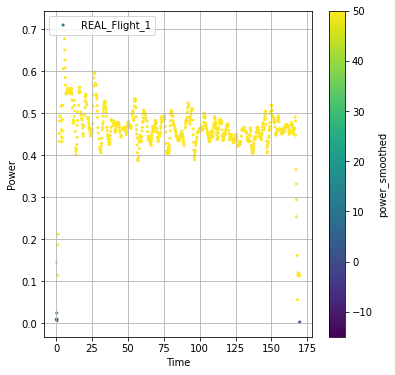

In [68]:
# Step 4: Display Real data
print(len(real_data_flight1))
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(real_data_flight1["time"],real_data_flight1['power_smoothed'] / 1e3,
            c=real_data_flight1[feature_under_study],
            s=4, label="REAL_Flight_1")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()


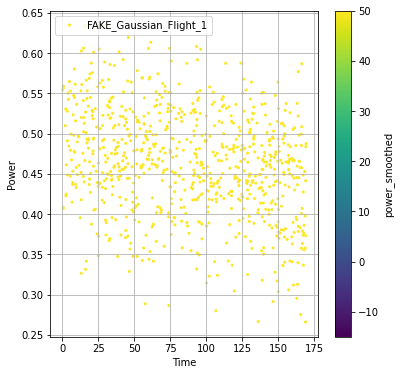

In [69]:
# Step 4: Display Synthetic data - Gaussian
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_Gaussian_flight1["time"],synthetic_data_Gaussian_flight1['power_smoothed'] / 1e3,
            c=synthetic_data_Gaussian_flight1[feature_under_study],
            s=4, label="FAKE_Gaussian_Flight_1")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

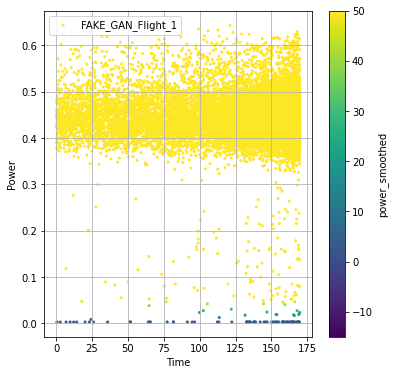

In [70]:
# Step 4: Display Synthetic data - GAN
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_GAN_flight1["time"],synthetic_data_GAN_flight1['power_smoothed'] / 1e3,
            c=synthetic_data_GAN_flight1[feature_under_study],
            s=4, label="FAKE_GAN_Flight_1")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

# Evaluating real / synthetic data

In [71]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data_flight1,
    synthesizer_Gaussian_flight1,
    metadata_flight1
)

AttributeError: 'GaussianCopulaSynthesizer' object has no attribute 'columns'

In [72]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=real_data_flight1,
    synthetic_data=synthetic_data_Gaussian_flight1,
    column_name='power_smoothed',
    metadata=metadata_flight1
)
    
fig.show()

In [73]:
from sdmetrics.reports.single_table import DiagnosticReport

report = DiagnosticReport()

In [74]:
report.generate(real_data_flight1, synthetic_data_Gaussian_flight1, metadata_flight1)

Creating report: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [75]:
report.get_results()

{'SUCCESS': ['Over 90% of the synthetic rows are not copies of the real data',
  'The synthetic data follows over 90% of the min/max boundaries set by the real data'],
 'WARNING': ['The synthetic data is missing more than 10% of the numerical ranges present in the real data'],
 'DANGER': []}

In [76]:
report.get_properties()

{'Coverage': 0.7328827737725258, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [77]:
for i in ['Synthesis', 'Coverage', 'Boundaries']:
    print("-> " + str(i) + ": ", report.get_details(property_name=i))

-> Synthesis:              Metric  Diagnostic Score  Num Matched Rows  Num New Rows
0  NewRowSynthesis               1.0                 0           815
-> Coverage:                     Column         Metric  Diagnostic Score
0                    time  RangeCoverage          0.996578
1              wind_speed  RangeCoverage          0.986451
2              wind_angle  RangeCoverage          1.000000
3              position_z  RangeCoverage          1.000000
4           orientation_x  RangeCoverage          0.703319
5           orientation_y  RangeCoverage          0.754121
6           orientation_z  RangeCoverage          1.000000
7           orientation_w  RangeCoverage          1.000000
8              velocity_x  RangeCoverage          0.671126
9              velocity_y  RangeCoverage          1.000000
10             velocity_z  RangeCoverage          1.000000
11              angular_x  RangeCoverage          0.389657
12              angular_y  RangeCoverage          0.515915
13     

In [78]:
for i in ['Synthesis', 'Coverage', 'Boundaries']:
    fig = report.get_visualization(property_name=i)
    fig.show()

In [79]:
print("RD_min", real_data_flight1['power_smoothed'].min())
print("RD_max", real_data_flight1['power_smoothed'].max())
print("SD_min", synthetic_data_Gaussian_flight1['power_smoothed'].min())
print("SD_max", synthetic_data_Gaussian_flight1['power_smoothed'].max())

RD_min 3.2630269885449703
RD_max 709.0351409967071
SD_min 265.98645038223094
SD_max 634.3123613646349
